### GradCAM
We will implement the GradCAM and apply it to the VGG-16 predictions.

\begin{equation*}
{\alpha}^{c}_{k} = \frac{1}{Z} \sum_{i} \sum_{j} \frac{\partial y^c}{\partial A_{ij}^{k}}
\end{equation*}


\begin{equation*}
{L}^{c}_{Grad-CAM} = ReLU (\sum_{k} {\alpha}^{c}_{k}{A^k} )
\end{equation*}



In [208]:
import torch
from PIL import Image
from torchvision import transforms
import torchvision.models as models

base_dir = "../data/"

In [239]:
input_tensor.shape

torch.Size([3, 224, 224])

In [209]:
def preprocess_image(image_path):
    """
    Preprocesses an image for VGG classifier.

    Args:
        image_path (str): Path to the image file.

    Returns:
        torch.Tensor: Preprocessed image as a PyTorch tensor.
    """
    # Define the transformations
    preprocess = transforms.Compose([
        transforms.Resize(256),  # Resize the image to 256x256 pixels
        transforms.CenterCrop(224),  # Crop the center 224x224 pixels
        transforms.ToTensor(),  # Convert the image to a PyTorch tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet values
    ])

    # Load the image
    image = Image.open(image_path).convert('RGB')

    # Apply the transformations
    image_tensor = preprocess(image)

    return image_tensor

In [249]:
image_path = base_dir + "red-breasted_merganser.jpeg"#"bulbul.jpeg"
input_tensor = preprocess_image(image_path)
input_batch = input_tensor.unsqueeze(0)

In [250]:
imagenet_classes_filepath = base_dir + "imagenet_classes.txt"
with open(imagenet_classes_filepath) as f:
    imagenet_classes = eval(f.read())

In [251]:
with torch.no_grad():
    output = vgg16_model(input_batch)

probabilities = torch.nn.functional.softmax(output[0], dim=0)
predicted_class = torch.argmax(probabilities).item()
predicted_label = imagenet_classes[predicted_class]

In [252]:
# Load the pre-trained VGG16 model
vgg16_model = models.vgg16(weights="VGG16_Weights.DEFAULT")

#Last rectified conv layer
vgg16_model.eval()
target_layer = vgg16_model.features[28]

def forward_hook_fn(module, input, output):
    global activations
    activations = output[0].detach()

def backward_hook_fn(module, input, output):
    global grad
    grad = output[0][0].detach()

hook_f = target_layer.register_forward_hook(forward_hook_fn)
hook_b = target_layer.register_backward_hook(backward_hook_fn)
output = vgg16_model(input_batch)
predicted_class = torch.argmax(output).item()

hook_f.remove()
hook_b.remove()
print(f"Predicted class: {predicted_class}")
loss = output[0][predicted_class]
model.zero_grad()
loss.backward()


Predicted class: 98


In [253]:
cam = (grad.mean(dim = 0).unsqueeze(0)*activations).sum(dim = 0)
cam = F.relu(cam)
cam = cam.unsqueeze(0).unsqueeze(0)
cam = F.interpolate(cam, input_tensor.shape[1:], mode='bilinear', align_corners=False)

In [254]:
cam = (grad.mean(dim = 0).unsqueeze(0)*activations).sum(dim = 0)
cam.max()

tensor(0.1332)

In [255]:
grad_averaged = grad.mean(dim = (1,2)).reshape(-1,1,1)
cam = grad_averaged*activations
cam = cam.sum(dim = 0).unsqueeze(0)
cam = cam.unsqueeze(0)
cam = F.interpolate(cam, input_tensor.shape[1:], mode='bilinear', align_corners=False)
cam_min = torch.min(cam)
cam_max = torch.max(cam)
cam -= cam_min
cam /= (cam_max - cam_min)

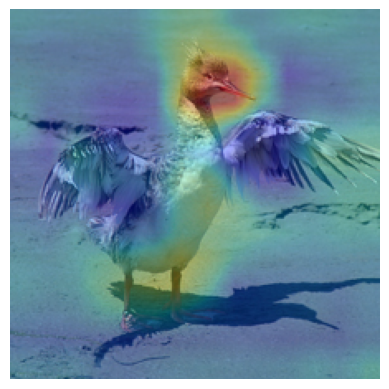

In [266]:
import matplotlib.pyplot as plt
min = input_tensor.min()
max = input_tensor.max()
input_tensor -= min
input_tensor /= (max - min)
plt.imshow(input_tensor.permute(1,2,0))
plt.imshow(cam[0][0], cmap='jet', alpha=0.3)
plt.axis('off')
plt.show()

In [ ]:
class GradCAM:

    def __init__(self, model, target_layer):
        self.target_layer = target_layer
        self.model = model
        self.activations = None
        self.grad = None

    def forward_hook_fn(self, module, input, output):
        self.activations = output.detach()

    def _register_hook(self):
        self.target_layer.register_forward_hook(forward_hook_fn)

    def extract_grad(self):
        self.target_layer.weight.grad.detach()

    def execute(self, image_path, target):
        
        
        